# OsuLearn
##### Machine Learning para jogar mapas de osu!

^^^

Isso aí, tô sem mais nada pra fazer, bora criar uma IA que joga osu! )o)

## Importar umas coisas...

In [1]:
# Machine Learning
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt

# Utilidades
import os
import math

Using TensorFlow backend.


## Constantes

Aqui tem uns caminhos para os arquivos que precisamos:

In [2]:
# Pasta do osu!
OSU_FOLDER = "C:\\" + os.path.join("Program Files (x86)", "Jogos", "osu!")

# Nome do beatmap
BEATMAP = os.path.join('499478 Utsu-P - TRAUMATIC', 'Utsu-P - TRAUMATIC (Cryptic) [EXTREME].osu')
#BEATMAP = os.path.join('353412 Sakuzyo - Imprinting', 'Sakuzyo - Imprinting (Necroluttah) [Arles AR9.5].osu')

# Nome do arquivo de replay
REPLAY = 'BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu.osr'
#REPLAY = 'BzMasked - Sakuzyo - Imprinting [Arles AR9.5] (2018-12-17) Osu.osr'

## Leitura do arquivo de Beatmap

O formato do arquivo está especificado no [site do osu!](https://osu.ppy.sh/help/wiki/osu!_File_Formats/Osu_(file_format)/).

In [3]:
import osu.beatmap

beatmap_filename = os.path.join(OSU_FOLDER, "Songs", BEATMAP)
beatmap = osu.beatmap.load(beatmap_filename)

print()
print('Mapa:', beatmap['ArtistUnicode'], '-', beatmap['TitleUnicode'])
print('Autor:', beatmap['Creator'])
print('Dificuldade: ', beatmap['Version'])


Mapa: 鬱P - TRAUMATIC
Autor: Cryptic
Dificuldade:  EXTREME


## Leitura do arquivo de Replay

O formato do arquivo está especificado no [site do osu!](https://osu.ppy.sh/help/wiki/osu!_File_Formats/Osr_(file_format)/).

In [4]:
import osu.replay

replay = osu.replay.load(os.path.join(OSU_FOLDER, "Replays", REPLAY))

## Informações do Replay

Legal, carregamos o replay, isso foi o que achamos:


Player: BzMasked

Pontuação Total: 417246

  137 x 300	   52 x 激
    6 x 100	    6 x 喝
    1 x 50	    1 x Erros

Acurácia: 95.98%
Combo Máximo: 138x 



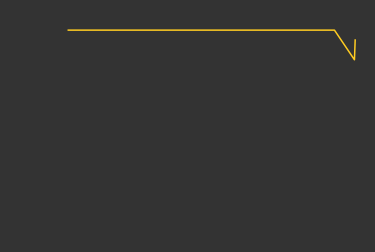

In [5]:
print()
print("Player:", replay.player)

print()
print("Pontuação Total:", replay.score)
print()
print("%5d x 300\t%5d x 激" % (replay.n_300s, replay.n_geki))
print("%5d x 100\t%5d x 喝" % (replay.n_100s, replay.n_katu))
print("%5d x 50\t%5d x Erros" % (replay.n_50s, replay.n_misses))
print()

print("Acurácia: %.2f%%" % (100 * replay.accuracy))
print("Combo Máximo: %dx" % replay.max_combo, "(Perfect)" if replay.perfect else "")
print()

%matplotlib inline

u = [int(t[0]) / 1000 for t in replay.life_graph]
v = [float(t[1]) for t in replay.life_graph]

fig = plt.figure(facecolor='#333333')
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(0, max(u) + 1)
ax.set_ylim(0, 1.1)
ax.axis('off')
ax.plot(u, v, '#ffcc22')
plt.show()

## Visualização

Aqui temos uma previsualização do replay, também:

In [6]:
%matplotlib notebook
#osu.replay.preview(beatmap, replay)

## Dados para treinamento...

In [7]:
def convert(data):
    targets = []
    result = []
    expected = []
    sqrt2 = math.sqrt(2)
    preempt, fadein = beatmap.approach_rate()
    
    t = 0
    last = None
    for r in data:
        w, x, y, z = r
        
        if w > 0:
            t += w
        else:
            continue
        
        objects = beatmap.visible_objects(t)
        
        if len(objects) == 0:
            continue
            
        if not last is None:
            dx = x - last[1]
            dy = last[2] - y
            
            distance = math.sqrt(dx ** 2 + dy ** 2) / (512 * sqrt2)
            
            if dx == 0:
                angle = 0 if dy == 0 else [math.pi / 2, -math.pi / 2][dy < 0]
            else:
                angle = math.atan(dy / dx)
            angle /= (2 * math.pi)
            
            left_click = z & 1
            right_click = (z & 2) >> 1
            expected.append(np.array([w, distance, angle, left_click, right_click]))
        
        last = r
            
        next_object = objects[0]
        for obj in objects[1:]:
            if t > obj[2] + preempt:
                break
            next_object = obj
        
        dx = x - next_object[0]
        dy = next_object[1] - y
        distance = math.sqrt(dx ** 2 + dy ** 2) / (512 * sqrt2)
        
        if dx == 0:
            angle = 0 if dy == 0 else [math.pi / 2, -math.pi / 2][dy < 0]
        else:
            angle = math.atan(dy / dx)
        angle /= (2 * math.pi)
            
        left_click = z & 1
        right_click = (z & 2) >> 1
        
        targets.append(w)
        result.append(np.array([next_object[2] + preempt - t, distance, angle, left_click, right_click]))
        
    expected.append(np.array([0, 0, 0, 0, 0]))
    
    return np.array(result), np.array(targets), np.array(expected)

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

pattern = os.path.join(OSU_FOLDER, "Replays", "*TRAUMATIC*EXTREME*.osr")
X = []
Y = []

from glob import glob

for file in glob(pattern):
    print(file)
    replay = osu.replay.load(file)
    data, targets, expected = convert(replay.data)
    X.append(data)
    Y.append(expected)
    
X = np.array(X)
Y = np.array(Y)
X = pad_sequences(X)
Y = pad_sequences(Y)

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.20, random_state = 36)
#X_train = np.reshape(X_train, (X_train.shape[0], 2202, 5))

C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (2).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (3).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (4).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (5).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (6).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (7).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (8).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu - Copia (9).osr
C:\Program Files (x86)\Jogos\osu!\Replays\BzMasked - Utsu-P - TRAUMATIC [EXTREME

## Finalmente: Modelo de rede neural LSTM

Agora começa a festa...

In [8]:
from keras.layers import LSTM, Embedding, Dense, Flatten

model = keras.models.Sequential()
model.add(LSTM(8, input_shape=(X_train.shape[1], 5), return_sequences=True))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2205, 8)           448       
_________________________________________________________________
dense_1 (Dense)              (None, 2205, 5)           45        
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
model.fit(X_train, Y_train, batch_size=32, epochs=1)

Epoch 1/1
14/14 [==============================] - 1s 42ms/step - loss: 17.7695 - acc: 0.9753
